# Chapter 7: k-Nearest Neighbors (kNN)

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt


## Table 7.1

In [2]:
mower_df = pd.read_csv('RidingMowers.csv')
mower_df['Number'] = mower_df.index + 1
mower_df.head(9)

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,1
1,85.5,16.8,Owner,2
2,64.8,21.6,Owner,3
3,61.5,20.8,Owner,4
4,87.0,23.6,Owner,5
5,110.1,19.2,Owner,6
6,108.0,17.6,Owner,7
7,82.8,22.4,Owner,8
8,69.0,20.0,Owner,9


In [3]:
trainData, validData = train_test_split(mower_df, test_size=0.4, random_state=26)
print(trainData.shape, validData.shape)
newHousehold = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}])
newHousehold

(14, 4) (10, 4)


,Income,Lot_Size
0,60,20


Scatter plot

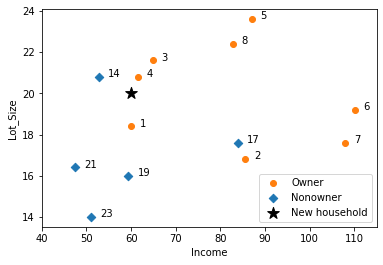

In [4]:
fig, ax = plt.subplots()

subset = trainData.loc[trainData['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker='o', label='Owner', color='C1')

subset = trainData.loc[trainData['Ownership']=='Nonowner']
ax.scatter(subset.Income, subset.Lot_Size, marker='D', label='Nonowner', color='C0')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*', label='New household', color='black', s=150)

plt.xlabel('Income')  # set x-axis label
plt.ylabel('Lot_Size')  # set y-axis label
for _, row in trainData.iterrows():
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))
    
handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

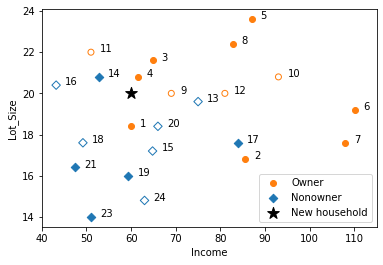

In [5]:
def plotDataset(ax, data, showLabel=True, **kwargs):
    subset = data.loc[data['Ownership']=='Owner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='o', label='Owner' if showLabel else None, color='C1', **kwargs)

    subset = data.loc[data['Ownership']=='Nonowner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='D', label='Nonowner' if showLabel else None, color='C0', **kwargs)

    plt.xlabel('Income')  # set x-axis label
    plt.ylabel('Lot_Size')  # set y-axis label
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

fig, ax = plt.subplots()

plotDataset(ax, trainData)
plotDataset(ax, validData, showLabel=False, facecolors='none')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*', label='New household', color='black', s=150)

plt.xlabel('Income')  # set x-axis label
plt.ylabel('Lot_Size')  # set y-axis label
    
handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

## Table 7.2
Initialize normalized training, validation, and complete data frames. Use the training data to learn the transformation.

In [6]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Income', 'Lot_Size']])  # Note the use of an array of column names

# Transform the full dataset
mowerNorm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]), 
                                    columns=['zIncome', 'zLot_Size']),
                       mower_df[['Ownership', 'Number']]], axis=1)
trainNorm = mowerNorm.iloc[trainData.index]
validNorm = mowerNorm.iloc[validData.index]
newHouseholdNorm = pd.DataFrame(scaler.transform(newHousehold), columns=['zIncome', 'zLot_Size'])

Use k-nearest neighbour

In [7]:
knn = NearestNeighbors(n_neighbors=3)
knn.fit(trainNorm[['zIncome', 'zLot_Size']])
distances, indices = knn.kneighbors(newHouseholdNorm)
print(trainNorm.iloc[indices[0], :])  # indices is a list of lists, we are only interested in the first element

     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


## Table 7.3
Initialize a data frame with two columns: `k` and `accuracy`

In [8]:
train_X = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_X = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

# Train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1       0.6
1    2       0.7
2    3       0.8
3    4       0.9
4    5       0.7
5    6       0.9
6    7       0.9
7    8       0.9
8    9       0.9
9   10       0.8
10  11       0.8
11  12       0.9
12  13       0.4
13  14       0.4


## Table 7.4

In [9]:
# Retrain with full dataset
mower_X = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors=4).fit(mower_X, mower_y)
distances, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))
print('Distances',distances)
print('Indices', indices)
print(mowerNorm.iloc[indices[0], :])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1
